In [3]:
import numpy as np 
import pandas as pd 

zillow_property_prices_smoothed = pd.read_csv('../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv')

zillow_property_prices_smoothed.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,208873.462679,...,490845.533375,493350.695688,494656.207341,494960.937814,494583.838161,494989.073345,495676.234520,496794.143551,497509.695217,497926.047244
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,129593.365790,...,559235.478588,567070.680150,573999.120407,579115.014448,583711.326153,588650.436294,594466.903640,599670.672459,602987.778333,604957.109985
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103665.724381,...,280680.665557,281640.782033,282174.775391,282135.030165,281900.616751,281718.894836,281530.681793,281114.059246,280326.473726,279597.721570
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,147260.760117,...,446622.168849,451108.583222,455706.631626,456405.579049,455899.283385,455269.896093,456224.469300,455977.746842,454758.212424,452507.615063
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,102393.669560,...,273891.035298,274882.471574,275384.557055,275217.811487,274925.444574,274652.769789,274399.856760,273892.947977,273294.320987,272955.477534
5,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,89151.023858,...,208323.383503,209707.139223,210812.805443,211321.018347,211541.068228,211702.246183,211965.099367,212152.875407,212307.344491,212486.901823
6,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,259443.363244,...,787606.507098,792360.984207,795349.747913,794847.999015,794632.943192,796433.687668,800382.673670,804352.841877,808000.281832,810946.520072
7,92593,8,78660,zip,TX,TX,Pflugerville,"Austin-Round Rock-Georgetown, TX",Travis County,156304.166643,...,401116.549062,400964.216862,400575.470960,399498.041983,398152.156570,397030.194172,396436.836348,395478.888147,394185.679083,392221.760795
8,62019,9,11208,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,181612.044889,...,668883.818235,673194.567398,676286.895239,676596.762947,677057.365476,678002.809500,680024.382051,680800.000205,680862.950623,679871.387222
9,95992,10,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,112947.199062,...,568519.381830,566911.400881,567898.089285,568866.155973,571433.606045,575394.597921,581124.896572,586310.738286,590832.543470,594352.410699


In [88]:
zillow_property_prices_smoothed['Metro'].value_counts().head(25)

Metro
New York-Newark-Jersey City, NY-NJ-PA           831
Chicago-Naperville-Elgin, IL-IN-WI              380
Los Angeles-Long Beach-Anaheim, CA              360
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     334
Washington-Arlington-Alexandria, DC-VA-MD-WV    320
Pittsburgh, PA                                  297
Boston-Cambridge-Newton, MA-NH                  272
Dallas-Fort Worth-Arlington, TX                 255
Minneapolis-St. Paul-Bloomington, MN-WI         225
St. Louis, MO-IL                                223
Houston-The Woodlands-Sugar Land, TX            220
Detroit-Warren-Dearborn, MI                     217
Atlanta-Sandy Springs-Alpharetta, GA            203
Kansas City, MO-KS                              188
Miami-Fort Lauderdale-Pompano Beach, FL         181
San Francisco-Oakland-Berkeley, CA              166
Seattle-Tacoma-Bellevue, WA                     156
Cincinnati, OH-KY-IN                            156
Baltimore-Columbia-Towson, MD                   150
Phoeni

In [90]:
# analyze and forecast home prices for a select metro area
import geopandas as gpd 
import warnings 
warnings.filterwarnings('ignore')

#look at a single metro-region...e.g. the tampa bay region (an area known for increased climate-induced risk w/ a booming real estate market)
sample = zillow_property_prices_smoothed.loc[zillow_property_prices_smoothed['Metro'] == 'Tampa-St. Petersburg-Clearwater, FL']

sample.head(10)
sample_cols = [
    'RegionName', 
    'Metro',
    'CountyName'
] + [
    i for i in sample.columns if len(i.split('-')) == 3
]
sample['RegionName'] = sample['RegionName'].astype(str)
sample = sample[sample_cols]

#find which zip codes are coastal? 
####zip-code metadata 
zip_path = 'datasets/State-zip-code-GeoJSON/fl_florida_zip_codes_geo.min.json'
read_file = gpd.read_file(zip_path)[['ZCTA5CE10','geometry','ALAND10','AWATER10']]
template_file = read_file.rename(columns={'ZCTA5CE10':'RegionName'})

#template_file.sort_values(by=['AWATER10'])
w_zip_census_attr = sample.merge(
    template_file, 
    how='inner', 
    on=['RegionName']
)

w_zip_census_attr.sort_values(by=['AWATER10'])

,RegionName,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,geometry,ALAND10,AWATER10
24,33543,"Tampa-St. Petersburg-Clearwater, FL",Pasco County,142350.914877,142540.958250,142789.990393,143343.337637,144071.616650,144744.078484,145386.237403,...,426286.964298,424536.677708,423359.400117,422445.297368,421513.420504,420076.649501,417960.051702,"POLYGON ((-82.29701 28.23186, -82.29634 28.231...",53215991,30832
67,33542,"Tampa-St. Petersburg-Clearwater, FL",Pasco County,67125.071954,67203.744491,67279.222959,67582.650926,67991.261905,68336.552772,68580.822648,...,240481.176216,239697.118948,239146.695574,238480.388040,237876.553140,236754.665795,236119.075956,"POLYGON ((-82.20638 28.25914, -82.20587 28.259...",27031553,110799
74,33714,"Tampa-St. Petersburg-Clearwater, FL",Pinellas County,57979.837482,57983.171780,58117.378532,58403.715903,58887.437172,59431.815513,59958.241491,...,285915.122169,285125.398481,284864.900779,284108.692119,283112.995235,280852.343785,278595.094303,"POLYGON ((-82.69898 27.82388, -82.69897 27.824...",9589008,138436
106,33765,"Tampa-St. Petersburg-Clearwater, FL",Pinellas County,98146.682369,98182.069695,98324.934877,98802.394057,99504.177825,100455.982563,101292.493894,...,372755.816521,370378.449359,368477.836723,366492.519232,364410.623211,361770.689654,359241.783918,"POLYGON ((-82.74366 27.95958, -82.74364 27.959...",10644801,177084
114,33540,"Tampa-St. Petersburg-Clearwater, FL",Pasco County,81627.108577,81872.097751,81944.508812,82076.689413,82203.171377,82402.259483,82774.648497,...,332027.217381,331295.641665,330746.789379,330333.000648,329771.443480,328888.870318,328247.426701,"MULTIPOLYGON (((-82.18624 28.27481, -82.18735 ...",90751526,189163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,33547,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,159361.103001,159504.480830,159335.371063,160043.539603,161459.554953,163292.937005,164697.762484,...,528858.825375,527974.900811,527117.589540,526264.367392,525482.213062,524694.437270,524068.139552,"POLYGON ((-82.18929 27.88415, -82.18937 27.883...",370616674,20762675
117,34614,"Tampa-St. Petersburg-Clearwater, FL",Hernando County,105697.999320,106845.988420,107746.156330,108950.517187,109655.709446,109643.164921,110155.440963,...,354510.866345,354746.562049,355143.945946,355649.591573,355768.002562,355238.366300,354867.021103,"POLYGON ((-82.52579 28.58451, -82.5264 28.5845...",195675594,21271790
30,33570,"Tampa-St. Petersburg-Clearwater, FL",Hillsborough County,106801.028143,106997.470363,107324.091426,107839.161239,108414.844384,109287.884967,110181.031654,...,347453.729947,345881.701015,344345.293312,342577.364356,340600.434579,338347.828410,336236.518662,"POLYGON ((-82.39247 27.66539, -82.39325 27.665...",102044862,21574658
123,33715,"Tampa-St. Petersburg-Clearwater, FL",Pinellas County,159316.774890,159539.531966,159846.838967,160799.970817,162359.528256,164453.117562,166547.548875,...,539733.864098,533488.065665,527874.903938,524452.231728,522833.041565,520807.343545,517790.924710,"POLYGON ((-82.74604 27.64875, -82.74266 27.672...",9453337,23658814


In [128]:
import matplotlib.pyplot as plt
#w_zip_census_attr['AWATER10'].hist(bins=25)
#plt.show()

w_zip_census_attr_trunc = w_zip_census_attr[['RegionName','2024-12-31', 'ALAND10','AWATER10']]
w_zip_census_attr_trunc = w_zip_census_attr_trunc\
    .rename(columns={'2024-12-31':'property_val_estimation'})\
    .set_index('RegionName') 
w_zip_census_attr_trunc['AWATER10_prop'] = \
w_zip_census_attr_trunc['AWATER10']/(w_zip_census_attr_trunc['ALAND10']+w_zip_census_attr_trunc['AWATER10'])

w_zip_census_attr_trunc.sort_values(by=['AWATER10']) 

#select some random zipcode
zip_sample = '33647'

#use k-NN matching to find the "optimal" comparison market (by zip)? 
#the optimal "match" should yield a similar averaged property value but "inverted" geo properties 
#that is, the origin zip is coastal but the matched zip is inland

#w_zip_census_attr_trunc.loc[zip_sample]

property_val_estimation    4.781700e+05
ALAND10                    8.777621e+07
AWATER10                   3.900537e+06
AWATER10_prop              4.254663e-02
Name: 33647, dtype: float64

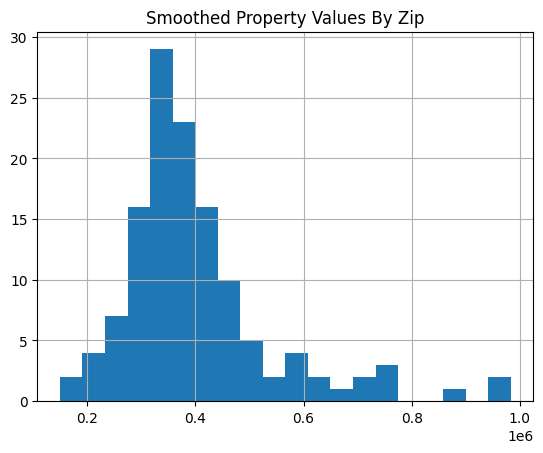

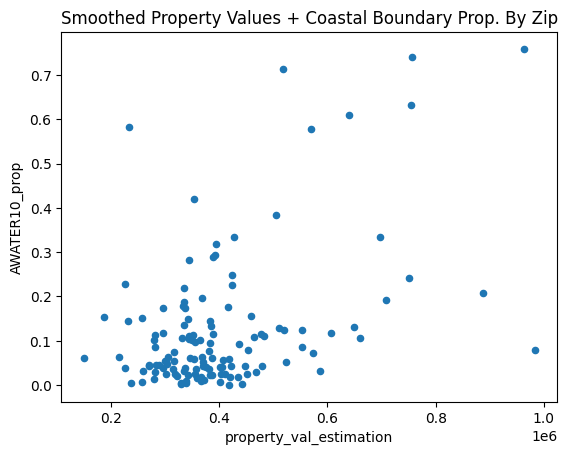

In [132]:
w_zip_census_attr_trunc['property_val_estimation'].hist(bins=20,)
plt.title('Smoothed Property Values By Zip')
plt.show()

w_zip_census_attr_trunc[['property_val_estimation','AWATER10_prop']]\
.plot(
    kind='scatter',
    x='property_val_estimation', 
    y='AWATER10_prop'
)
plt.title('Smoothed Property Values + Coastal Boundary Prop. By Zip')
plt.show()

In [222]:
k_optimal_matches = 1

sample_zip = w_zip_census_attr_trunc.loc[zip_sample]

zips_cp = w_zip_census_attr_trunc.copy()
zips_cp = zips_cp.iloc[1:]
zips_cp['rank_propval'] = (-1*np.abs(sample_zip['property_val_estimation']-zips_cp['property_val_estimation'])).rank()
zips_cp['rank_coastprop'] = np.abs(sample_zip['AWATER10_prop']-zips_cp['AWATER10_prop']).rank()
zips_cp['MATCH SCORE'] = zips_cp['rank_propval']+zips_cp['rank_coastprop']
zips_cp=zips_cp.sort_values(by=['MATCH SCORE'], ascending=False)

matches = zips_cp.head(k_optimal_matches)
matches

,property_val_estimation,ALAND10,AWATER10,AWATER10_prop,rank_propval,rank_coastprop,MATCH SCORE
RegionName,,,,,,,
33715,517790.92471,9453337,23658814,0.714505,117.0,126.0,243.0


In [224]:
sample_zip

property_val_estimation    4.781700e+05
ALAND10                    8.777621e+07
AWATER10                   3.900537e+06
AWATER10_prop              4.254663e-02
Name: 33647, dtype: float64

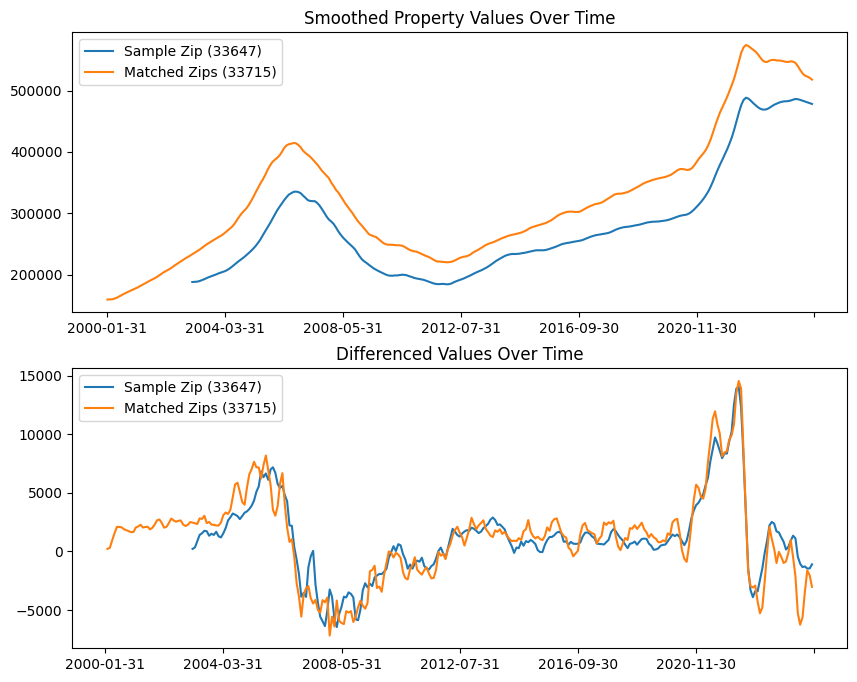

In [252]:
grpA = w_zip_census_attr.loc[w_zip_census_attr['RegionName']==zip_sample]
grpB = w_zip_census_attr.loc[w_zip_census_attr['RegionName'].isin(matches.index)]

ts_col = [i for i in sample.columns if len(i.split('-')) == 3]

ts_A = grpA[ts_col].T
ts_B = grpB[ts_col].mean(axis=0).T
combined = pd.concat((ts_A,ts_B), axis=1) 
combined.columns=[f'Sample Zip ({zip_sample})', f"Matched Zips ({','.join(matches.index)})"]

fig,ax = plt.subplots(2,1,figsize=(10,8))
combined.plot(ax=ax[0],title='Smoothed Property Values Over Time')
combined.diff().plot(ax=ax[1], title='Differenced Values Over Time')
plt.show()

In [10]:
import duckdb
region_str = ', FL'
con = duckdb.connect('../datasets/combined_data.db')
df = con.sql(f"select * from zillow_home_prices where Metro ilike '%{region_str}%'").df()
cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3 and int(i.split('-')[0]) < 2020]
zillow_df = df[cols]
zillow_df = zillow_df.rename(
            columns={
                'RegionName':'zip'
            }
        )

In [11]:
def generate_real_estate_shiftindex(historical_discount_factor=0.0005):
        
        def weighting_fn(df, alpha):
            df=df.dropna()
            N=len(df)
            w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
            w_norm = w/w.sum() 
            v = 1e3*(df.T@w_norm)
            return v
            
        ts=zillow_df.set_index('zip').drop(columns=['Metro','CountyName']).T
        
        ts_roc = ts.diff().div(ts)
        ts_roc_qtr_smoothed = ts_roc.rolling(4).mean()
        print(ts_roc_qtr_smoothed)
        
        return weighting_fn(ts_roc_qtr_smoothed, historical_discount_factor)

generate_real_estate_shiftindex()

zip            34787     34953     33024     33411     33025     33311  \
2000-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-02-29       NaN       NaN       NaN       NaN       NaN       NaN   
2000-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
2000-05-31  0.005995  0.000727  0.005268  0.004339  0.003792  0.004959   
...              ...       ...       ...       ...       ...       ...   
2019-08-31  0.004470  0.001514  0.000082  0.001212  0.000054  0.003747   
2019-09-30  0.004611  0.000993  0.000713  0.001797  0.000336  0.004687   
2019-10-31  0.004361  0.000885  0.001980  0.002463  0.001282  0.005687   
2019-11-30  0.004171  0.001324  0.003947  0.003060  0.002996  0.007436   
2019-12-31  0.003989  0.002338  0.006120  0.003468  0.004818  0.010017   

zip            33023     33012     33015     33186  ...     34661     33854  \
2000-01-31       NaN       NaN  

zip
34787    0.0
34953    0.0
33024    0.0
33411    0.0
33025    0.0
        ... 
33051    0.0
34681    0.0
34138    0.0
33855    0.0
32664    0.0
Length: 881, dtype: float64

In [12]:
con.close()